_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: A. Shlychkov, A. Gittel, E. Seiffert

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-25 12:34:01CEST

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

sklearn: 1.4.1.post1

pandas    : 2.2.1
numpy     : 1.26.4
matplotlib: 3.8.3

Watermark: 2.4.3



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<unknown>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_50572/2453566246.py:20: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)


(3663, 17965)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [4]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
average_expression = np.mean(counts, axis=0)
# Compute the fraction of zeros for each gene
fraction_zeros = np.mean(counts == 0, axis=0)

In [5]:
# Compute the Poisson prediction

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
fraction_zeros_poisson = np.exp(-average_expression)  # Poisson distribution
# fraction_zeros_poisson = np.random.poisson(average_expression)  # Poisson distribution

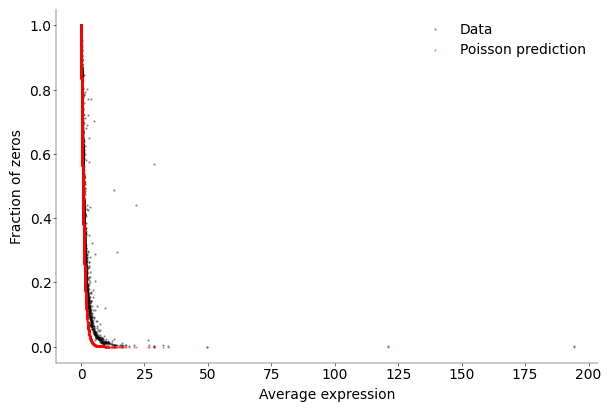

In [6]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(
    average_expression, fraction_zeros, s=1, color="black", label="Data", alpha=0.5
)
ax.scatter(
    average_expression,
    fraction_zeros_poisson,
    s=1,
    color="red",
    label="Poisson prediction",
    alpha=0.5,
)
# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Fraction of zeros")
# add legend
ax.legend()
plt.show()

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [7]:
# Compute the variance of the expression counts of each gene
variance_expression = np.var(counts, axis=0)

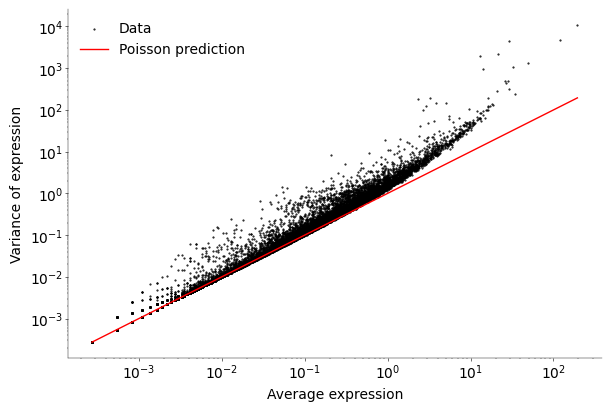

In [8]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------
ax.scatter(average_expression, variance_expression, s=1, color="black", label="Data")

# add Poisson prediction
ax.plot(
    np.unique(average_expression),
    np.unique(average_expression),
    color="red",
    label="Poisson prediction",
)
# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# add legend
ax.legend()

# make axis logarithmix
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [9]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.

fano = variance_expression / average_expression

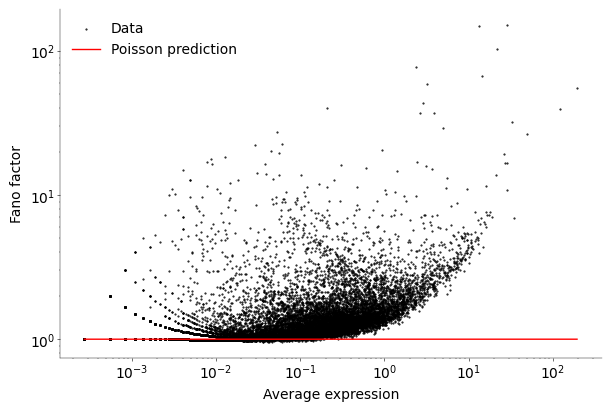

In [10]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------

ax.scatter(average_expression, fano, s=1, color="black", label="Data")

# add Poisson prediction
ax.plot(
    np.unique(average_expression),
    np.ones(np.unique(average_expression).shape),
    color="red",
    label="Poisson prediction",
)
# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Fano factor")
# add legend
ax.legend()

# make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

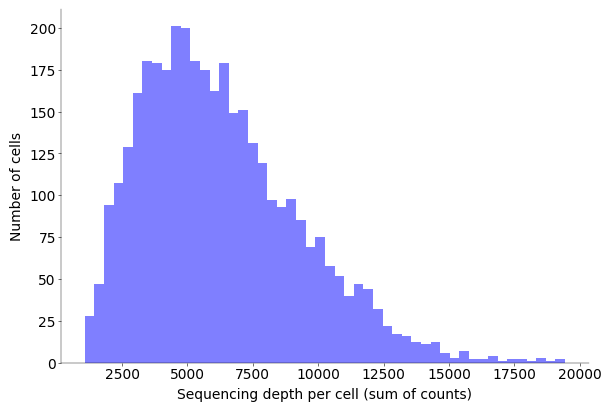

In [11]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

ax.hist(counts.sum(axis=1), bins=50, color="blue", alpha=0.5)
# add labels
ax.set_xlabel("Sequencing depth per cell (sum of counts)")
ax.set_ylabel("Number of cells")
plt.show()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [12]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------
normalized_counts = counts / counts.sum(axis=1)[:, None] * np.median(counts.sum(axis=1))

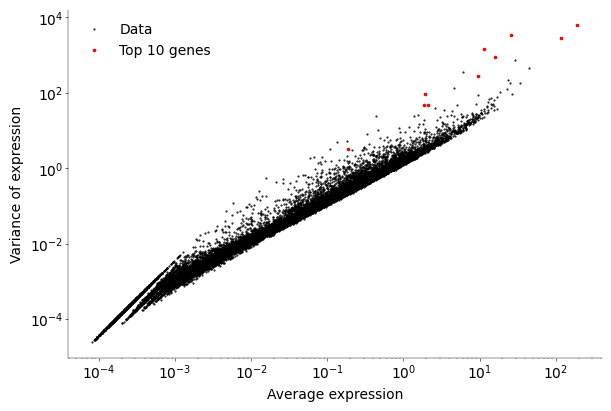

In [13]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
ax.scatter(
    np.mean(normalized_counts, axis=0),
    np.var(normalized_counts, axis=0),
    s=1,
    color="black",
    label="Data",
)

# mark the top 10 genes
top10 = np.argsort(fano)[-10:]
ax.scatter(
    np.mean(normalized_counts, axis=0)[top10],
    np.var(normalized_counts, axis=0)[top10],
    s=10,
    color="red",
    label="Top 10 genes",
)
# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# add legend
ax.legend()
# make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [14]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array

top10_genes = genes[top10]
top10_fano = fano[top10]
top10_sorted = np.argsort(top10_fano)[::-1]
top10_genes = top10_genes[top10_sorted]
top10_fano = top10_fano[top10_sorted]
for gene, fano in zip(top10_genes, top10_fano):
    print(f"{gene}: Fano Factor: {fano:.2f}")

Sst: Fano Factor: 151.10
Npy: Fano Factor: 149.00
Cck: Fano Factor: 103.28
Pcp4: Fano Factor: 77.84
Cnr1: Fano Factor: 66.80
Kctd12: Fano Factor: 58.62
Malat1: Fano Factor: 55.18
Pvalb: Fano Factor: 43.79
Apoe: Fano Factor: 40.30
Meg3: Fano Factor: 39.69


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [15]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------


# log-transform the data
log_counts = np.log1p(counts)

# Square root transform the data
sqrt_counts = np.sqrt(counts)

# Transform the counts into normalized counts (as above)
normalized_counts = counts / counts.sum(axis=1)[:, None] * np.median(counts.sum(axis=1))

# Select all genes with the normalized Fano factor above 3 and remove the rest
selected_genes = genes[fano > 3]

In [16]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform


from sklearn.decomposition import PCA

# perform PCA

pca = PCA()
pca.fit(counts)
pca_counts = pca.transform(counts)

pca_log = PCA()
pca_log.fit(log_counts)
pca_log_counts = pca.transform(log_counts)

pca_sqrt = PCA()
pca_sqrt.fit(sqrt_counts)
pca_sqrt_counts = pca.transform(sqrt_counts)


# get the first 2 principal components
pca_counts_2 = pca_counts[:, :2]
pca_log_counts_2 = pca_log_counts[:, :2]
pca_sqrt_counts_2 = pca_sqrt_counts[:, :2]

pcas = [pca_counts_2, pca_log_counts_2, pca_sqrt_counts_2]

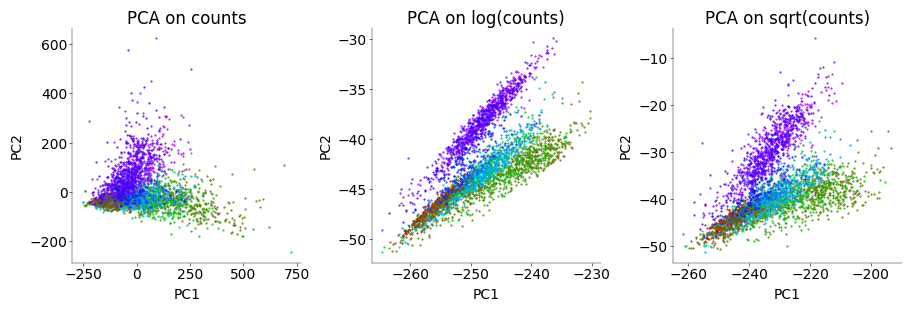

In [17]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# axs[0].scatter(pca_counts[:, 0], pca_counts[:, 1], s=1, color="black")
# axs[0].set_title("PCA on counts")
# axs[1].scatter(pca_log_counts[:, 0], pca_log_counts[:, 1], s=1, color="black")
# axs[1].set_title("PCA on log(counts)")
# axs[2].scatter(pca_sqrt_counts[:, 0], pca_sqrt_counts[:, 1], s=1, color="black")
# axs[2].set_title("PCA on sqrt(counts)")

# add labels
for ax in axs:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# add colores to the clusters for earch subplot

for a, ax in enumerate(axs):
    for i, cluster in enumerate(clusterNames):
        ax.scatter(
            pcas[a][clusters == i, 0],
            pcas[a][clusters == i, 1],
            s=1,
            color=clusterColors[i],
            label=cluster,
        )

# add title
axs[0].set_title("PCA on counts")
axs[1].set_title("PCA on log(counts)")
axs[2].set_title("PCA on sqrt(counts)")


plt.show()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [18]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs
tsne = TSNE()
tsne_counts = tsne.fit(pca_counts[:, :50])

tsne_log = TSNE(n_components=2, random_state=42)
tsne_log_counts = tsne.fit(pca_log_counts[:, :50])

tsne_sqrt = TSNE(n_components=2, random_state=42)
tsne_sqrt_counts = tsne.fit(pca_sqrt_counts[:, :50])


tsnes = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]


# Use default settings of openTSNE


# You can also use sklearn if you want

from sklearn.manifold import TSNE as TSNE_sk

tsne_sk = TSNE_sk()
tsne_counts_sk = tsne_sk.fit_transform(pca_counts[:, :50])
tsne_log_counts_sk = tsne_sk.fit_transform(pca_log_counts[:, :50])
tsne_sqrt_counts_sk = tsne_sk.fit_transform(pca_sqrt_counts[:, :50])

tsnes_sk = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]

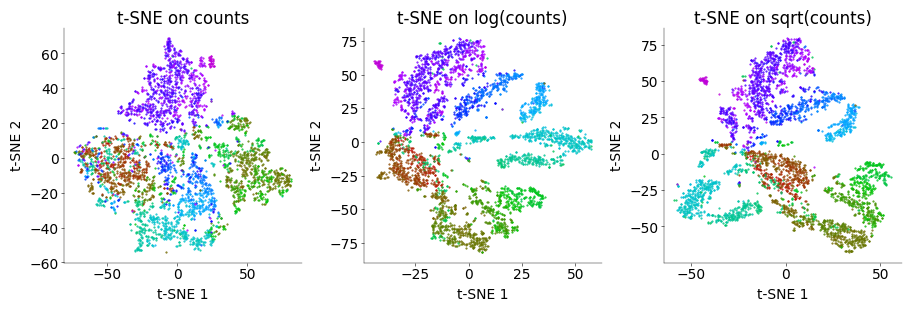

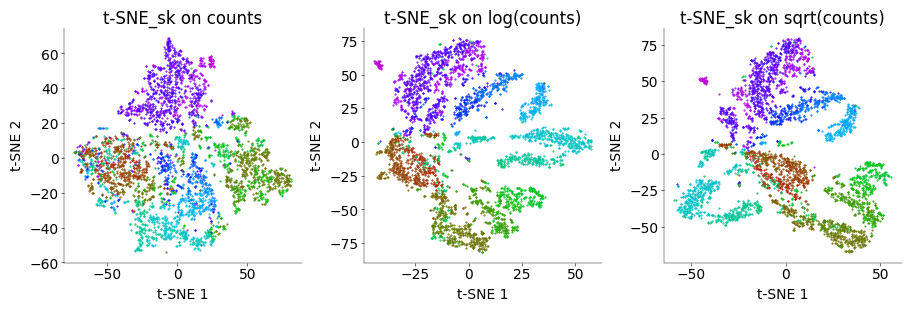

In [19]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# add plot

for a, ax in enumerate(axs):
    for i, cluster in enumerate(clusterNames):
        ax.scatter(
            tsnes[a][clusters == i, 0],
            tsnes[a][clusters == i, 1],
            s=1,
            color=clusterColors[i],
            label=cluster,
        )

# add labels
for ax in axs:
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

# add title
axs[0].set_title("t-SNE on counts")
axs[1].set_title("t-SNE on log(counts)")
axs[2].set_title("t-SNE on sqrt(counts)")

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# add plot

for a, ax in enumerate(axs):
    for i, cluster in enumerate(clusterNames):
        ax.scatter(
            tsnes_sk[a][clusters == i, 0],
            tsnes_sk[a][clusters == i, 1],
            s=1,
            color=clusterColors[i],
            label=cluster,
        )

# add labels
for ax in axs:
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

# add title
axs[0].set_title("t-SNE_sk on counts")
axs[1].set_title("t-SNE_sk on log(counts)")
axs[2].set_title("t-SNE_sk on sqrt(counts)")

plt.show()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [20]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [21]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15

A = kneighbors_graph(tsne_counts, 15, mode="connectivity", include_self=False)

# Transform it into an igraph object

sources, targets = A.nonzero()
G = ig.Graph(directed=False)
G.add_vertices(A.shape[0])
G.add_edges(list(zip(sources, targets)))

In [22]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type

part = la.find_partition(G, la.RBConfigurationVertexPartition, n_iterations=5, seed=42)

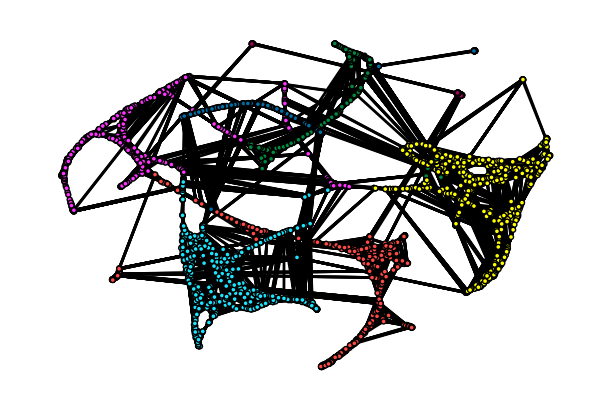

In [28]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, ax = plt.subplots(figsize=(6, 4))
ig.plot(
    G,
    vertex_size=5,
    vertex_color=clusterCols[part.membership],
    edge_color="black",
    target=ax,
)
ax.set_title("Leiden clustering")

#### [Note] Below are the attempts to plot manually because the igraph package didn't work initially

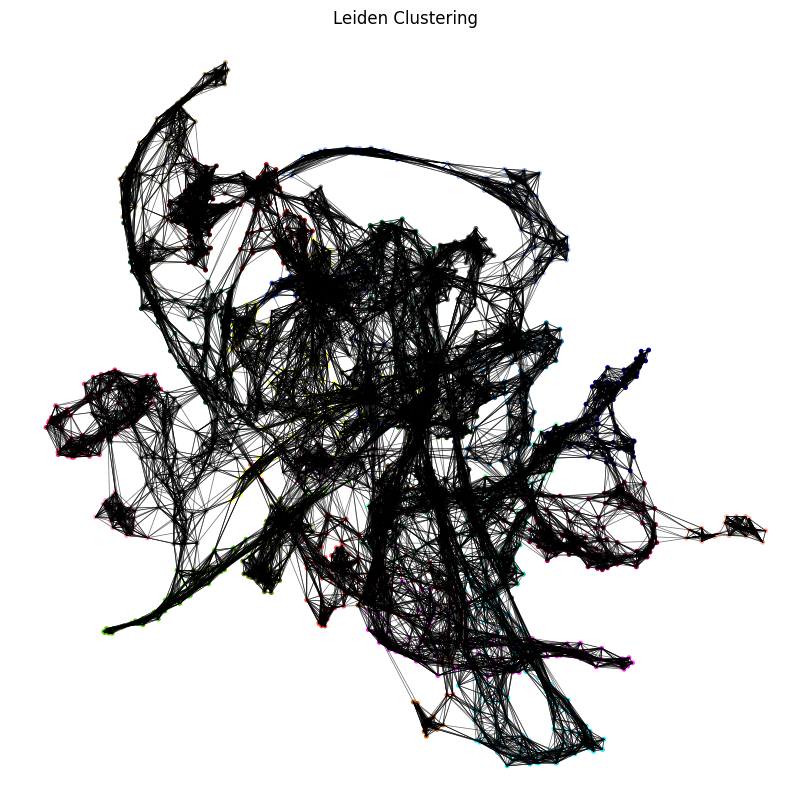

In [23]:
# Extract the layout from igraph
layout = G.layout("fr")

# Extract coordinates for vertices
x_coords = [layout[k][0] for k in range(G.vcount())]
y_coords = [layout[k][1] for k in range(G.vcount())]

# Extract edges
edges = G.get_edgelist()

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Draw edges
for edge in edges:
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    ax.plot([x0, x1], [y0, y1], color="black", lw=0.5, alpha=0.6)

# Draw vertices
ax.scatter(
    x_coords, y_coords, c=[clusterCols[cluster] for cluster in part.membership], s=25
)

# Add title
ax.set_title("Leiden Clustering")

# Hide axes
ax.axis("off")

# Display the plot
plt.show()

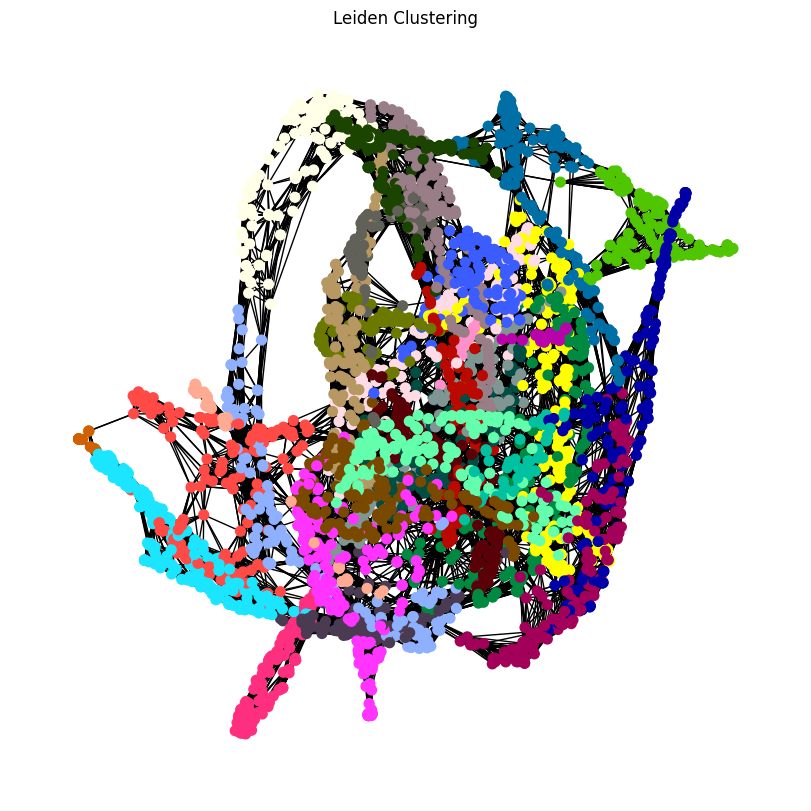

In [24]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

# I installed the networkx package to plot the results, since ig.plot relies on pycairo/, which is not available on Windows
import networkx as nx

# Convert igraph to networkx graph
G_nx = nx.Graph()
G_nx.add_nodes_from(range(G.vcount()))
G_nx.add_edges_from(G.get_edgelist())

# Get the positions for the nodes using spring layout
pos = nx.spring_layout(G_nx)

# Draw the graph using networkx and matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Draw the nodes with cluster colors
nx.draw_networkx_nodes(
    G_nx,
    pos,
    node_size=50,
    node_color=[clusterCols[cluster] for cluster in part.membership],
    ax=ax,
)

# Draw the edges
nx.draw_networkx_edges(G_nx, pos, edge_color="black", ax=ax)

# Add title
ax.set_title("Leiden Clustering")

# Hide axes
ax.axis("off")

# Show plot
plt.show()

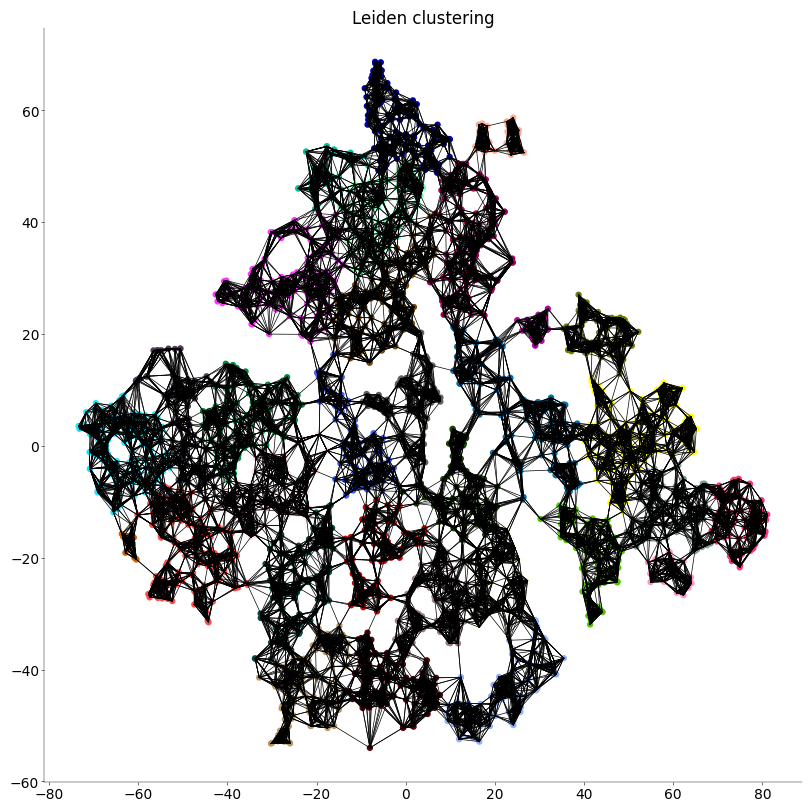

In [25]:
# Get the clusters
clusters = np.array(part.membership)

# Create a scatter plot for the nodes
fig, ax = plt.subplots(figsize=(8, 8))
pos = tsne_counts  # Using the t-SNE coordinates for the node positions

# Draw the edges
for source, target in zip(sources, targets):
    ax.plot(
        [pos[source, 0], pos[target, 0]], [pos[source, 1], pos[target, 1]], "k-", lw=0.5
    )

# Draw the nodes
sc = ax.scatter(pos[:, 0], pos[:, 1], c=clusterCols[clusters], s=50)

# Add title
ax.set_title("Leiden clustering")

# Show plot
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [26]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

part1 = la.find_partition(
    G,
    la.RBConfigurationVertexPartition,
    n_iterations=5,
    seed=42,
    resolution_parameter=0.5,
)
part2 = la.find_partition(
    G,
    la.RBConfigurationVertexPartition,
    n_iterations=5,
    seed=42,
    resolution_parameter=2,
)
part3 = la.find_partition(
    G,
    la.RBConfigurationVertexPartition,
    n_iterations=5,
    seed=42,
    resolution_parameter=0.1,
)

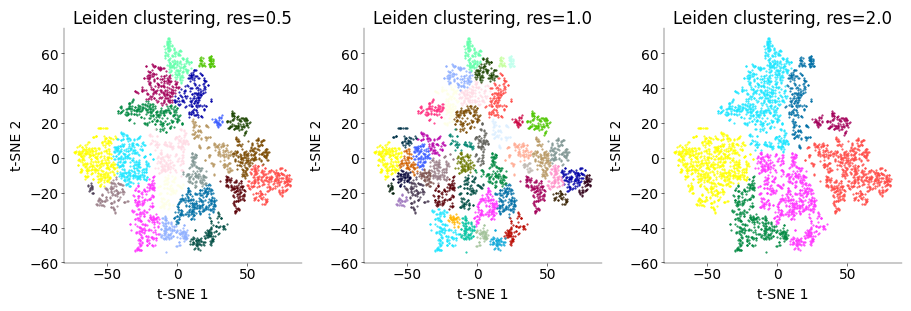

In [27]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

for i, part in enumerate([part1, part2, part3]):
    for j, cluster in enumerate(np.unique(part.membership)):
        axs[i].scatter(
            tsne_counts[part.membership == cluster, 0],
            tsne_counts[part.membership == cluster, 1],
            s=1,
            color=clusterCols[j],
            label=cluster,
        )

    # add labels
    axs[i].set_xlabel("t-SNE 1")
    axs[i].set_ylabel("t-SNE 2")

    # add title
    axs[i].set_title(f"Leiden clustering, res={0.5 * 2 ** i}")

plt.show()

Text(0.5, 1.0, 'Leiden clustering, res=0.1')

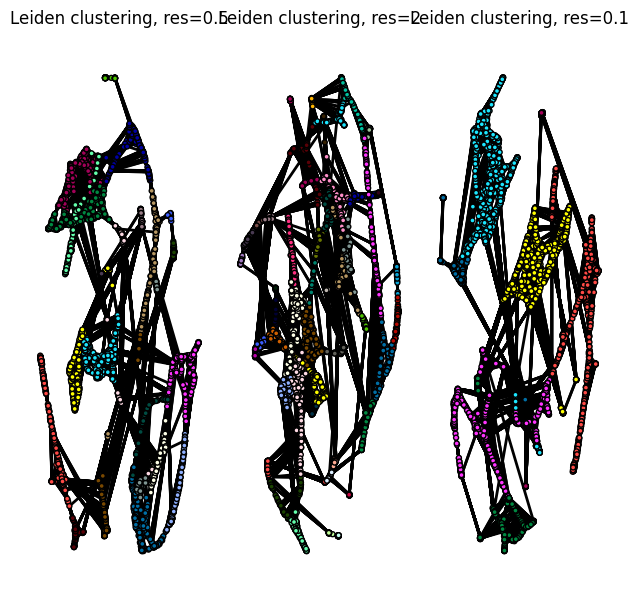

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(6, 6))
ig.plot(
    G,
    vertex_size=5,
    vertex_color=clusterCols[part1.membership],
    edge_color="black",
    target=ax[0],
)
ig.plot(
    G,
    vertex_size=5,
    vertex_color=clusterCols[part2.membership],
    edge_color="black",
    target=ax[1],
)
ig.plot(
    G,
    vertex_size=5,
    vertex_color=clusterCols[part3.membership],
    edge_color="black",
    target=ax[2],
)
ax[0].set_title("Leiden clustering, res=0.5")
ax[1].set_title("Leiden clustering, res=2")
ax[2].set_title("Leiden clustering, res=0.1")